<a href="https://colab.research.google.com/github/tomasz-soltysiak/Fraud_transaction/blob/tomaszscript/Fraud_dedection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.patches as mpatches
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score,roc_curve,confusion_matrix,roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from keras.layers import Dense
from keras.layers import Dropout
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
#from keras.metrics import precision, binary_recall, f1_score




In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


After adding libraries, I upload data.

In [4]:
df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/data.csv')
df.head()



,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,127614.0,2.004188,-0.287498,-1.984934,0.342239,0.413188,-0.815346,0.445456,-0.299258,0.562445,0.109932,-1.381862,-0.428037,-1.230877,0.629739,-0.242149,-0.388169,-0.137390,-0.552790,0.315548,-0.152272,-0.038661,-0.127194,0.036464,0.504076,0.176423,0.541252,-0.121212,-0.064948,64.99,0
1,139389.0,2.346905,-1.264915,-1.034900,-1.568721,-1.122435,-0.790624,-1.011732,-0.268243,-1.229191,1.576645,-1.286030,-0.816409,0.603102,-0.437890,-0.164642,-0.582255,0.427399,-0.134499,-0.049048,-0.460329,-0.196288,0.015015,0.197023,-0.432445,-0.119139,-0.131627,0.015176,-0.058104,1.00,0
2,68482.0,-3.089671,2.464689,0.042745,1.670674,-2.129076,0.600262,-1.627286,2.452801,0.319063,-0.526330,-1.681347,1.951140,1.001432,0.346440,-1.625289,-1.128464,1.888585,-1.045530,1.149073,-0.060298,-0.223384,-0.441265,0.250283,0.091483,-0.038373,-0.410096,0.088944,0.026973,30.70,0
3,123677.0,1.792358,-0.384458,-2.170063,0.096243,0.291162,-1.510182,0.921037,-0.525263,-0.088484,0.119203,1.171025,1.013250,-0.123025,1.041171,-0.323426,-0.460035,-0.465857,-0.061338,0.309959,0.072457,0.297749,0.633531,-0.176001,0.146116,0.342753,0.198887,-0.117734,-0.061706,154.09,0
4,121222.0,2.188008,-0.400212,-1.627908,-0.225692,-0.133549,-1.273351,0.226144,-0.553975,-0.908684,0.877520,-0.845913,0.763512,1.478457,0.027869,-0.734253,-2.244708,0.184697,0.251184,-0.646467,-0.558023,-0.338599,-0.220436,0.112804,0.049313,0.157236,0.606729,-0.063450,-0.071105,10.00,0


In [0]:
df.info()
df.describe()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213605 entries, 0 to 213604
Data columns (total 31 columns):
Time      213605 non-null float64
V1        213605 non-null float64
V2        213605 non-null float64
V3        213605 non-null float64
V4        213605 non-null float64
V5        213605 non-null float64
V6        213605 non-null float64
V7        213605 non-null float64
V8        213605 non-null float64
V9        213605 non-null float64
V10       213605 non-null float64
V11       213605 non-null float64
V12       213605 non-null float64
V13       213605 non-null float64
V14       213605 non-null float64
V15       213605 non-null float64
V16       213605 non-null float64
V17       213605 non-null float64
V18       213605 non-null float64
V19       213605 non-null float64
V20       213605 non-null float64
V21       213605 non-null float64
V22       213605 non-null float64
V23       213605 non-null float64
V24       213605 non-null float64
V25       213605 non-null float64
V26  

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000
mean,94763.710592,0.000761,-0.000864,-0.000395,-0.000124,0.000037,-0.001235,-0.000793,0.000741,0.002086,-0.002382,0.000110,-0.000659,-0.000949,0.000634,0.000574,0.000392,0.001007,0.000294,-0.000233,0.000381,0.000008,0.000888,-0.000716,-0.000077,0.000786,0.000293,-0.000320,-0.000183,88.408696,0.001727
std,47521.370536,1.959843,1.656822,1.514786,1.412014,1.367172,1.324434,1.218273,1.194886,1.098027,1.087479,1.020825,0.998508,0.995958,0.958802,0.914407,0.874088,0.849561,0.837742,0.813287,0.765076,0.729790,0.726021,0.632531,0.605641,0.522326,0.482457,0.401070,0.328280,248.726927,0.041527
min,0.000000,-56.407510,-72.715728,-33.680984,-5.683171,-42.147898,-26.160506,-43.557242,-50.943369,-13.434066,-24.588262,-4.797473,-18.553697,-4.008640,-19.214325,-4.498945,-13.563273,-25.162799,-9.335193,-7.213527,-23.646890,-22.889347,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-11.710896,0.000000,0.000000
25%,54113.000000,-0.919923,-0.597928,-0.891674,-0.845828,-0.693702,-0.768408,-0.555589,-0.208845,-0.639825,-0.535966,-0.763252,-0.405836,-0.649770,-0.426259,-0.579815,-0.466294,-0.483418,-0.498483,-0.456560,-0.211881,-0.228160,-0.541214,-0.161916,-0.353719,-0.316995,-0.327013,-0.070970,-0.052880,5.580000,0.000000
50%,84629.000000,0.019950,0.065295,0.180284,-0.018836,-0.055078,-0.274951,0.040626,0.022431,-0.048788,-0.094571,-0.032840,0.139530,-0.014834,0.050698,0.048705,0.068072,-0.064990,-0.003878,0.003635,-0.063053,-0.029198,0.007580,-0.011943,0.041112,0.017457,-0.052342,0.001158,0.011244,22.000000,0.000000
75%,139282.000000,1.315599,0.803606,1.028480,0.743107,0.611668,0.398198,0.569214,0.327296,0.599340,0.449416,0.739790,0.617635,0.662074,0.493322,0.650082,0.522930,0.399906,0.500882,0.457928,0.131932,0.186690,0.527844,0.146825,0.439075,0.352142,0.241358,0.090808,0.078129,77.010000,0.000000
max,172792.000000,2.451888,22.057729,9.382558,16.875344,34.801666,23.917837,44.054461,19.587773,15.594995,23.745136,12.018913,4.846452,4.569009,7.754599,5.825654,7.059132,9.207059,5.041069,5.591971,39.420904,27.202839,8.361985,20.803344,4.016342,7.519589,3.517346,12.152401,33.847808,19656.530000,1.000000


In [6]:
df=df.dropna(axis=0)
df.isnull().sum(axis=0)

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

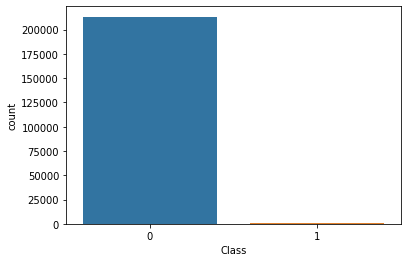

In [0]:
sns.countplot(df['Class'])


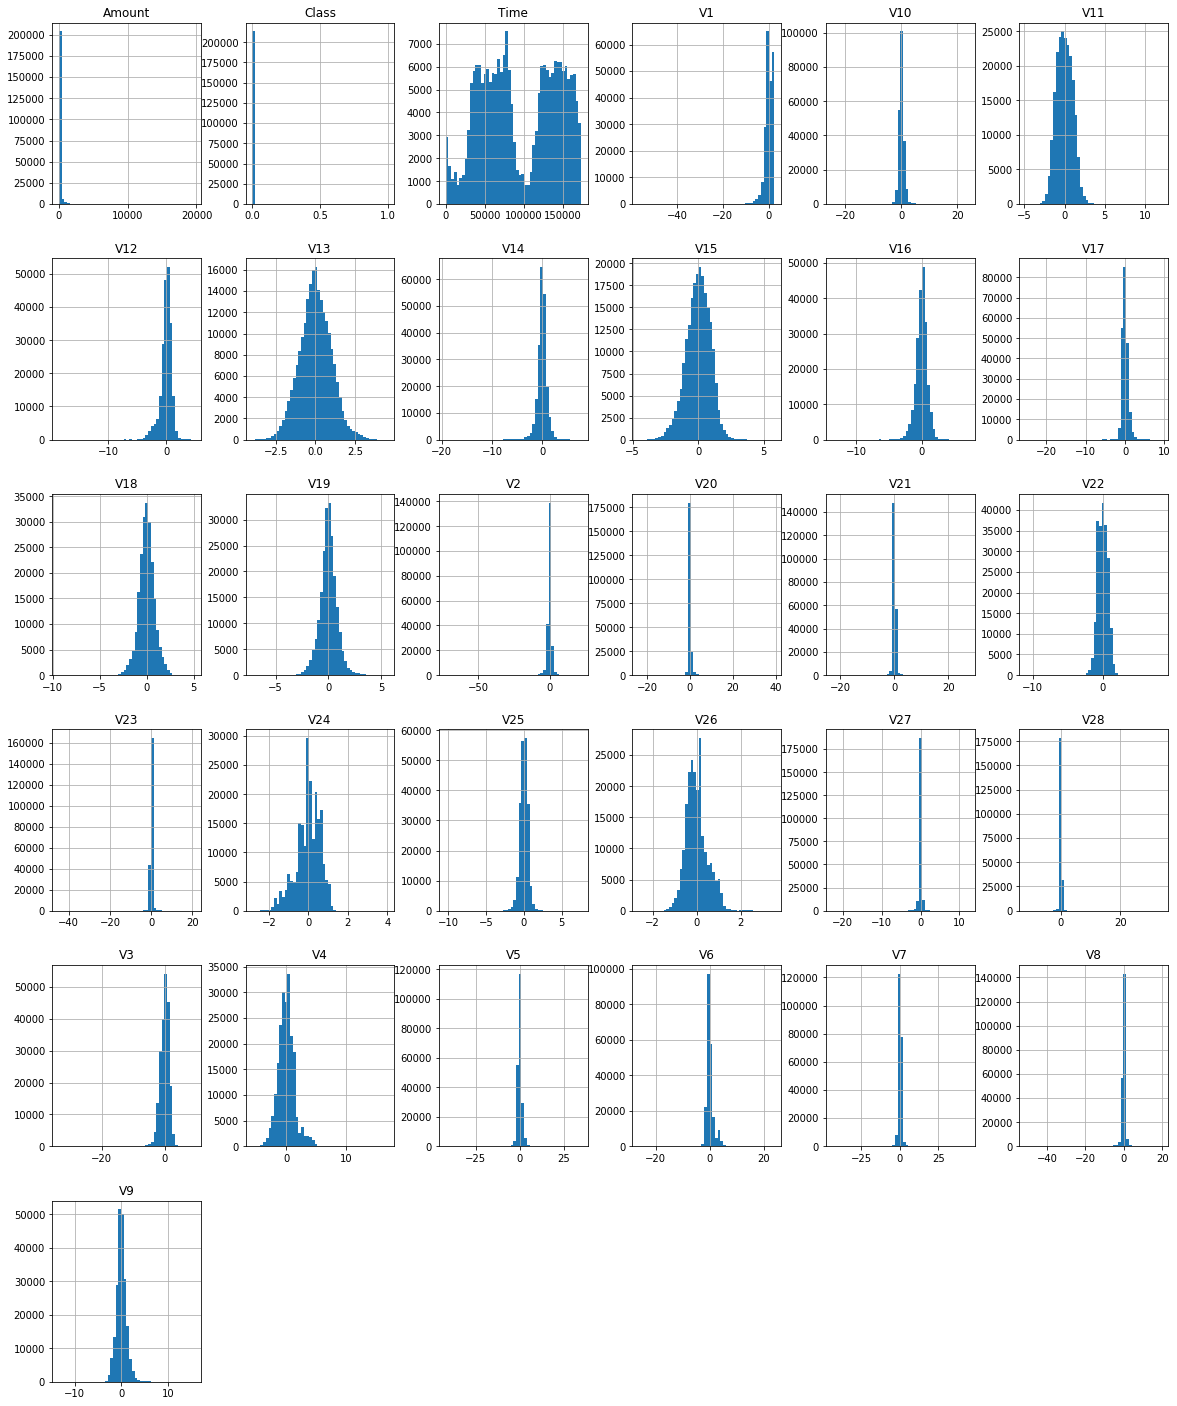

In [0]:

df.hist(bins=50,figsize=(20,25))

plt.show()

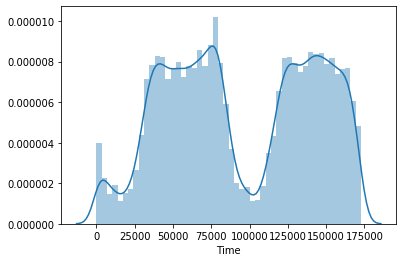

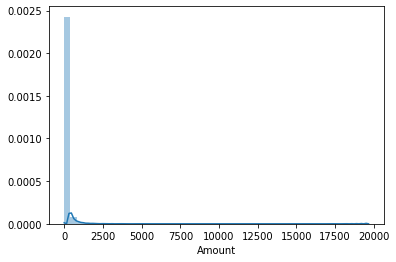

In [0]:
plt.figure()
sns.distplot(df['Time'])
plt.figure()
sns.distplot(df['Amount'])


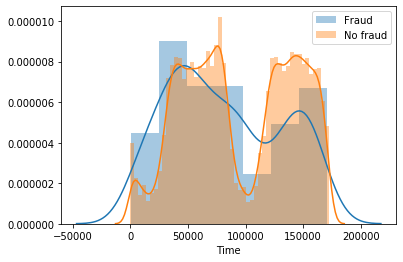

In [0]:
df['scaled_time']=round((df['Time']/3600)%24)
df.head()
df_fraud=df[df['Class']==1]
df_nofraud=df[df['Class']==0]
sns.distplot(df_fraud['Time'])
sns.distplot(df_nofraud['Time'])
plt.legend(labels=['Fraud','No fraud'])

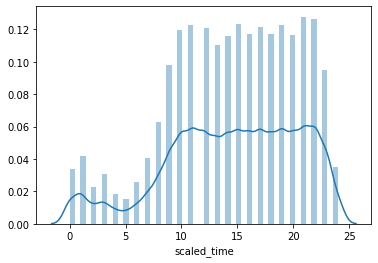

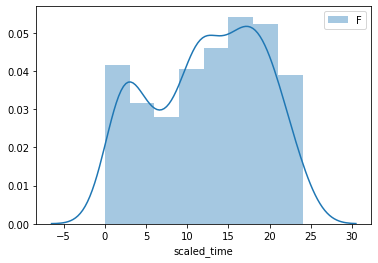

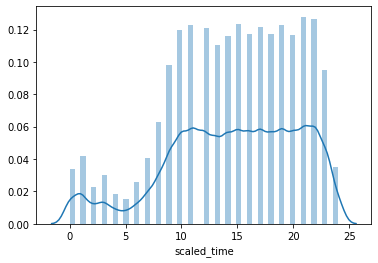

In [0]:
np.floor((172792/3600)%24)
np.floor((89000/3600)%24)


sns.distplot(df['scaled_time'])
plt.figure()
sns.distplot(df_fraud['scaled_time'])
plt.legend('Fraud')
plt.figure()
sns.distplot(df_nofraud['scaled_time'])

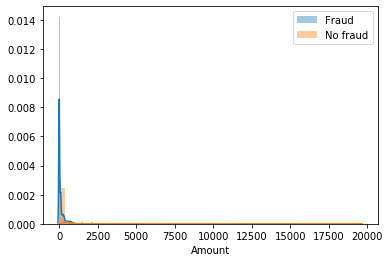

In [0]:
sns.distplot(df_fraud['Amount'])
sns.distplot(df_nofraud['Amount'])
plt.legend(labels=['Fraud','No fraud'])

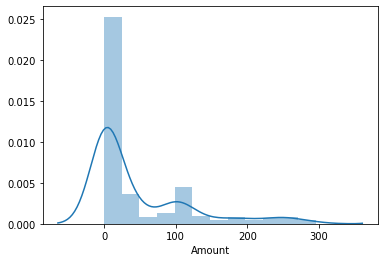

In [0]:

sns.distplot(df_fraud[df_fraud['Amount']<300]['Amount'])

In [0]:
df_fraud.info()
df_fraud.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369 entries, 1122 to 212910
Data columns (total 31 columns):
Time      369 non-null float64
V1        369 non-null float64
V2        369 non-null float64
V3        369 non-null float64
V4        369 non-null float64
V5        369 non-null float64
V6        369 non-null float64
V7        369 non-null float64
V8        369 non-null float64
V9        369 non-null float64
V10       369 non-null float64
V11       369 non-null float64
V12       369 non-null float64
V13       369 non-null float64
V14       369 non-null float64
V15       369 non-null float64
V16       369 non-null float64
V17       369 non-null float64
V18       369 non-null float64
V19       369 non-null float64
V20       369 non-null float64
V21       369 non-null float64
V22       369 non-null float64
V23       369 non-null float64
V24       369 non-null float64
V25       369 non-null float64
V26       369 non-null float64
V27       369 non-null float64
V28       369 non-nul

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.0
mean,81742.769648,-4.586912,3.607730,-6.839043,4.405857,-3.091104,-1.360680,-5.422950,0.484907,-2.545094,-5.549502,3.635253,-6.102522,-0.117007,-6.841104,-0.050836,-4.088737,-6.562522,-2.225902,0.686498,0.387236,0.766251,0.013921,0.081441,-0.104428,0.050772,0.047553,0.148435,0.084942,110.438157,1.0
std,48471.700261,6.694782,4.312807,6.931307,2.849054,5.274777,1.850759,7.181037,7.064123,2.501627,4.824995,2.668387,4.584707,1.116228,4.262592,1.054479,3.824035,6.957197,2.887444,1.518055,1.401716,4.067469,1.550562,1.114900,0.530055,0.770953,0.480527,1.332533,0.518405,221.502314,0.0
min,406.000000,-29.876366,-8.402154,-30.558697,-1.313275,-21.665654,-6.406267,-43.557242,-41.044261,-13.434066,-24.588262,-1.702228,-18.553697,-3.127795,-19.214325,-4.498945,-13.563273,-25.162799,-9.335193,-3.681904,-4.128186,-22.797604,-8.887017,-5.988806,-2.028024,-2.167510,-1.152671,-7.263482,-1.796363,0.000000,1.0
25%,41313.000000,-5.839192,1.189757,-8.451410,2.230778,-4.409844,-2.445140,-7.281328,-0.164910,-3.838399,-7.297803,1.880602,-8.576761,-1.012791,-9.377878,-0.590224,-6.366500,-11.644603,-4.568859,-0.221267,-0.158971,0.105593,-0.531496,-0.304666,-0.434643,-0.325033,-0.263934,-0.019579,-0.098173,1.000000,1.0
50%,75033.000000,-2.303350,2.708535,-5.111658,4.028391,-1.433055,-1.419748,-3.005953,0.672409,-2.042416,-4.594952,3.480602,-5.403768,-0.067498,-6.679977,-0.044180,-3.562534,-5.231425,-1.524505,0.626059,0.274027,0.594623,0.043807,-0.041461,-0.060327,0.068951,-0.002601,0.389152,0.144774,9.820000,1.0
75%,129308.000000,-0.361428,4.864535,-2.220907,6.320089,0.175739,-0.411924,-0.974073,1.869838,-0.788388,-2.516628,5.138547,-2.824946,0.681222,-4.211756,0.690010,-1.359389,-1.312059,0.055604,1.589582,0.808336,1.242896,0.624207,0.320133,0.298242,0.456090,0.400348,0.782036,0.383869,105.990000,1.0
max,170348.000000,2.132386,22.057729,2.250210,11.864868,9.880564,6.474115,5.802537,19.587773,3.353525,3.245086,12.018913,1.375941,2.815440,1.571080,2.471358,3.139656,6.739384,3.790316,5.228342,11.059004,27.202839,8.361985,5.466230,1.091435,2.156042,2.745261,2.352333,1.773326,2125.870000,1.0


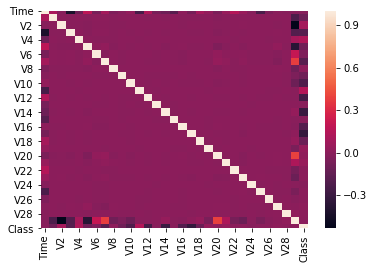

In [0]:
sns.heatmap(df.corr())

Przejdźmy do skalowania danych. 
Musimy się zastanowić, jak chcemy przeskalować Amount i Time.
Nie sugerujcie się tym co zakodowałem, myślę, że wczoraj na prezentacjach były przedstawione ciekawsze metody poradzenia sobie z czasem. Jak np przypisanie informacji binarnej o czy transakcja została wykonana pomiędzy określonymi godzinami.
Co do amount myślę, że zaproponowany sposób skalowania jest git, ale oczywiście można to zrobić standaryzacją lub innym skalerem.


In [0]:
Rob_scaler=RobustScaler()

df['scaled_Amount']=Rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,scaled_time,scaled_Amount
0,127614.0,2.004188,-0.287498,-1.984934,0.342239,0.413188,-0.815346,0.445456,-0.299258,0.562445,0.109932,-1.381862,-0.428037,-1.230877,0.629739,-0.242149,-0.388169,-0.137390,-0.552790,0.315548,-0.152272,-0.038661,-0.127194,0.036464,0.504076,0.176423,0.541252,-0.121212,-0.064948,64.99,0,11.0,0.601848
1,139389.0,2.346905,-1.264915,-1.034900,-1.568721,-1.122435,-0.790624,-1.011732,-0.268243,-1.229191,1.576645,-1.286030,-0.816409,0.603102,-0.437890,-0.164642,-0.582255,0.427399,-0.134499,-0.049048,-0.460329,-0.196288,0.015015,0.197023,-0.432445,-0.119139,-0.131627,0.015176,-0.058104,1.00,0,15.0,-0.293994
2,68482.0,-3.089671,2.464689,0.042745,1.670674,-2.129076,0.600262,-1.627286,2.452801,0.319063,-0.526330,-1.681347,1.951140,1.001432,0.346440,-1.625289,-1.128464,1.888585,-1.045530,1.149073,-0.060298,-0.223384,-0.441265,0.250283,0.091483,-0.038373,-0.410096,0.088944,0.026973,30.70,0,19.0,0.121798
3,123677.0,1.792358,-0.384458,-2.170063,0.096243,0.291162,-1.510182,0.921037,-0.525263,-0.088484,0.119203,1.171025,1.013250,-0.123025,1.041171,-0.323426,-0.460035,-0.465857,-0.061338,0.309959,0.072457,0.297749,0.633531,-0.176001,0.146116,0.342753,0.198887,-0.117734,-0.061706,154.09,0,10.0,1.849223
4,121222.0,2.188008,-0.400212,-1.627908,-0.225692,-0.133549,-1.273351,0.226144,-0.553975,-0.908684,0.877520,-0.845913,0.763512,1.478457,0.027869,-0.734253,-2.244708,0.184697,0.251184,-0.646467,-0.558023,-0.338599,-0.220436,0.112804,0.049313,0.157236,0.606729,-0.063450,-0.071105,10.00,0,10.0,-0.167997


Tutaj przedstawię mój sposób na przeskalowanie

Poniżej tego komentarza jest miejsce by każdy z nas zaproponował swój model.
Proponuje swoją część kodu rozdzielić pisaniem pogrubionego imienia.
Powyżej będziemy jeszcze te dane dopracowywać. Wiadomo jeśli ktoś chcę może po swojemu przekształcić dane do modelu.

Musimy rozważyć jak radzimy sobie z niezbalansowaniem danych.
Możemy wykonać:
- modele na orginalnym zbiorze
- undersampling
- oversampling
Na koniec porównać wyniki.

Co do modeli, myślę, że warto użyć przynajmniej kilku:
Ja sprawdzę: Logistic Regresion, Decision Tree, NN....


**TOMEK**

In [0]:
# Wykonam model regresji logistycznej dla wszystkich danych
df=df.drop(columns=['Time','Amount'])



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Precision equals 0.9016393442622951
f1` score equals0.6875
recall equals0.5555555555555556
0.9990637054791955


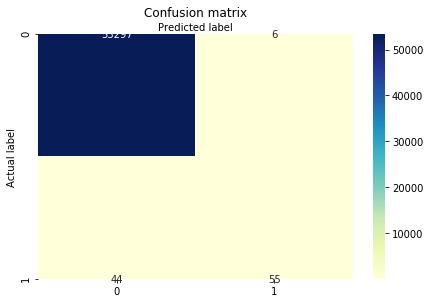

In [0]:
X=df.drop(columns=['Class'])
y=df['Class']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)
log_reg=LogisticRegression()
log_reg.fit(X_train,y_train)
y_pred=log_reg.predict(X_test)



cnf_matrix = confusion_matrix(y_test, y_pred)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print('Precision equals '+ str(precision_score(y_test,y_pred)))
print('f1` score equals'+ str(f1_score(y_test,y_pred)))
print('recall equals' +str(recall_score(y_test,y_pred)))
print(accuracy_score(y_test,y_pred))


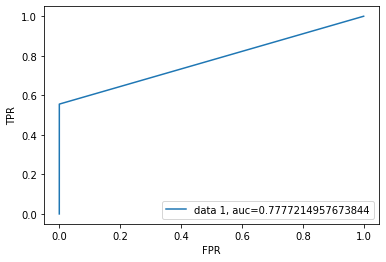

In [0]:
# Wykonam ROC CURVE dla wybranego modelu
fpr, tpr, trashhold = roc_curve(y_test,  y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

Natępnie porównam modele, i na jednym rysynku narysuje ROC dla wielu modeli by wybrać ten najlepszy.

Zacznę od napisania zdefiniowania funkcji, które będa mi zwracać chciane wartości na temat badanego modelu.

In [7]:
def Log_reg(X,y):
  X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)
  log_reg=LogisticRegression()
  log_reg.fit(X_train,y_train)
  y_pred=log_reg.predict(X_test)

  cnf_matrix = confusion_matrix(y_test, y_pred)
  precision=precision_score(y_test,y_pred)
  accuracy=accuracy_score(y_test,y_pred)
  f1=f1_score(y_test,y_pred)
  recall=recall_score(y_test,y_pred)
  fpr, tpr, trashhold = roc_curve(y_test,  y_pred)
  auc=roc_auc_score(y_test, y_pred)
  return cnf_matrix,precision,accuracy,f1,recall,fpr,tpr,trashhold,auc
X=df.drop(columns=['Class'])
y=df['Class']
Log_reg(X,y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(array([[53280,    23],
        [   42,    57]]),
 0.7125,
 0.9987828171229542,
 0.6368715083798883,
 0.5757575757575758,
 array([0.00000000e+00, 4.31495413e-04, 1.00000000e+00]),
 array([0.        , 0.57575758, 1.        ]),
 array([2, 1, 0]),
 0.7876630401722798)

In [0]:
def Rand_forest(X,y):
  X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)
  RF=RandomForestClassifier(n_estimators=150)
  RF.fit(X_train,y_train)
  y_pred=RF.predict(X_test)

  cnf_matrix = confusion_matrix(y_test, y_pred)
  precision=precision_score(y_test,y_pred)
  accuracy=accuracy_score(y_test,y_pred)
  recall=recall_score(y_test,y_pred)
  f1=f1_score(y_test,y_pred)
  auc=roc_auc_score(y_test, y_pred)
  fpr, tpr, trashhold = roc_curve(y_test,  y_pred)
  return cnf_matrix,precision,accuracy,f1,recall,fpr,tpr,trashhold,auc


In [0]:
def KNeig(X,y):
  X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)
  Kneig=KNeighborsClassifier(n_neighbors=5)
  Kneig.fit(X_train,y_train)
  y_pred=Kneig.predict(X_test)

  cnf_matrix = confusion_matrix(y_test, y_pred)
  precision=precision_score(y_test,y_pred)
  accuracy=accuracy_score(y_test,y_pred)
  recall=recall_score(y_test,y_pred)
  f1=f1_score(y_test,y_pred)
  auc=roc_auc_score(y_test, y_pred)
  fpr, tpr, trashhold = roc_curve(y_test,  y_pred)
  return cnf_matrix,precision,accuracy,f1,recall,fpr,tpr,trashhold,auc


In [9]:
def SVC_(X,y):
  X=X.iloc[0:5000]
  y=y.iloc[0:5000]
  Sscaler=StandardScaler()
  X=Sscaler.fit_transform(X)
  X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)
  svc=SVC(kernel='rbf',random_state=0,gamma=1,C=1)
  svc.fit(X_train,y_train)
  y_pred=svc.predict(X_test)

  cnf_matrix = confusion_matrix(y_test, y_pred)
  precision=precision_score(y_test,y_pred)
  accuracy=accuracy_score(y_test,y_pred)
  recall=recall_score(y_test,y_pred)
  f1=f1_score(y_test,y_pred)
  auc=roc_auc_score(y_test, y_pred)
  fpr, tpr, trashhold = roc_curve(y_test,  y_pred)
  return cnf_matrix,precision,accuracy,f1,recall,fpr,tpr,trashhold,auc

X=df.drop(columns=['Class'])
y=df['Class']
SVC_(X,y)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(array([[1247,    0],
        [   3,    0]]),
 0.0,
 0.9976,
 0.0,
 0.0,
 array([0., 1.]),
 array([0., 1.]),
 array([1, 0]),
 0.5)

In [10]:
def XGBoost_(X,y):
  
  
  X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)
  xgb=XGBClassifier()
  xgb.fit(X_train,y_train)
  y_pred=xgb.predict(X_test)
  

  cnf_matrix = confusion_matrix(y_test, y_pred)
  precision=precision_score(y_test,y_pred)
  accuracy=accuracy_score(y_test,y_pred)
  recall=recall_score(y_test,y_pred)
  f1=f1_score(y_test,y_pred)
  auc=roc_auc_score(y_test, y_pred)
  fpr, tpr, trashhold = roc_curve(y_test,  y_pred)
  return cnf_matrix,precision,accuracy,f1,recall,fpr,tpr,trashhold,auc

X=df.drop(columns=['Class'])
y=df['Class']
print(XGBoost_(X,y))

(array([[53299,     4],
       [   26,    73]]), 0.948051948051948, 0.9994382232875173, 0.8295454545454545, 0.7373737373737373, array([0.00000000e+00, 7.50426805e-05, 1.00000000e+00]), array([0.        , 0.73737374, 1.        ]), array([2, 1, 0]), 0.8686493473466065)


In [13]:
#Neural NEtwork
def NN_(X,y):
  scaler=StandardScaler()
  scaler.fit_transform(X)
  X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)  
  model = Sequential()

  
  model.add(Dense(11, activation='relu', input_shape=(30,)))
 
  model.add(Dense(121, activation='relu'))

  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy',
              optimizer='adam',
              )
  early_stopping_monitor = EarlyStopping(patience=2)                 
  model.fit(X_train, y_train,epochs=5, batch_size=1, verbose=1, validation_data=(X_test,y_test),callbacks=[early_stopping_monitor])

  model.evaluate(X_test,y_test)
  y_pred = model.predict_classes(X_test)

  cnf_matrix = confusion_matrix(y_test, y_pred)
  precision=precision_score(y_test,y_pred)
  accuracy=accuracy_score(y_test,y_pred)
  recall=recall_score(y_test,y_pred)
  f1=f1_score(y_test,y_pred)
  auc=roc_auc_score(y_test, y_pred)
  fpr, tpr, trashhold = roc_curve(y_test,  y_pred)

  return cnf_matrix,precision,accuracy,f1,recall,fpr,tpr,trashhold,auc
X=df.drop(columns=['Class'])
y=df['Class']
print(NN_(X,y))




Train on 160203 samples, validate on 53402 samples
Epoch 1/5





160203/160203 [==============================] - 242s 2ms/step - loss: 0.0489 - val_loss: 0.0299
Epoch 2/5
160203/160203 [==============================] - 242s 2ms/step - loss: 0.0272 - val_loss: 0.0299
Epoch 3/5
53402/53402 [==============================] - 1s 18us/step
(array([[53303,     0],
       [   99,     0]]), 0.0, 0.9981461368488072, 0.0, 0.0, array([0., 1.]), array([0., 1.]), array([1, 0], dtype=int32), 0.5)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
X=df.drop(columns=['Class'])
y=df['Class']

cnf_matrixLog_reg,precisionLog_reg,accuracyLog_reg,f1Log_reg,recall_Log_reg,fprLog_reg,tprLog_reg,trashholdLog_reg,AUCLog_reg=Log_reg(X,y)
cnf_matrixRF,precisionRF,accuracyRF,f1RF,recallRF,fprRF,tprRF,trashholdRF,AUCRF = Rand_forest(X,y)
cnf_matrixKN,precisionKN,accuracyKN,f1KN,recallKN,fprKN,tprKN,trashholdKN,aucKN=KNeig(X,y)
cnf_matrixSVC,precisionSVC,accuracySVC,f1SVC,recallSVC,fprSVc,tprSVc,trashholdSVc,aucSVC=SVC_(X,y)
cnf_matrixXGB,precisionXGB,accuracyXGB,f1XGB,recallXGB,fprXGB,tprXGB,trashholdXGB,aucXGB=XGBoost_(X,y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


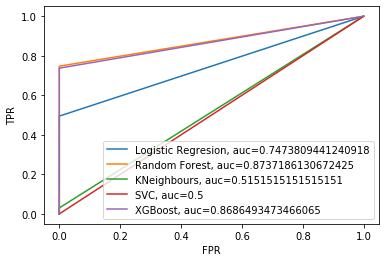

In [0]:
plt.plot(fprLog_reg,tprLog_reg,label="Logistic Regresion, auc="+str(AUCLog_reg))
plt.plot(fprRF,tprRF,label="Random Forest, auc="+str(AUCRF))
plt.plot(fprKN,tprKN,label="KNeighbours, auc="+str(aucKN))
plt.plot(fprSVc,tprSVc,label="SVC, auc="+str(aucSVC))
plt.plot(fprXGB,tprXGB,label="XGBoost, auc="+str(aucXGB))
plt.legend(loc=4)

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()